In [1]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import random
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier

SEED = 42
random.seed(SEED)

df = pd.read_csv('synthetic_letters_text_only.csv')
df

,letter,label
0,"To Whom It May Concern,\n\nI regret to write t...",negative
1,"To Whom It May Concern,\n\nI regret to inform ...",negative
2,"To Whom It May Concern,\n\nI am pleased to rec...",positive
3,"To whom it may concern,\n\nI am writing to rec...",neutral
4,"To Whom It May Concern,\n\nI regret to inform ...",negative
...,...,...
195,"To whom it may concern,\n\nI regret to inform ...",negative
196,"To Whom It May Concern,\n\nI regret to inform ...",negative
197,"Dear [Recipient's Name],\n\nI regret to inform...",negative
198,"To whom it may concern,\n\nI am pleased to rec...",positive


In [2]:
train, rest = train_test_split(df, test_size=0.5, random_state=SEED)
valid, test = train_test_split(rest, test_size=0.5, random_state=SEED)

encoder = SentenceTransformer("all-MiniLM-L6-v2")
X_train = encoder.encode(list(train.letter))
X_valid = encoder.encode(list(valid.letter))
X_test = encoder.encode(list(test.letter))

y_train = list(train.label)
y_valid = list(valid.label)
y_test = list(test.label)

In [3]:
def evaluate_logistic_regression_model(X_train, y_train, X_test, y_test):
    model = SGDClassifier(loss='log_loss', random_state=SEED)
    model.fit(X_train, y_train)
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    return { 'train_acc': train_acc, 'test_acc': test_acc, }

In [4]:
evaluate_logistic_regression_model(X_train, y_train, X_test, y_test)

{'train_acc': 0.99, 'test_acc': 0.86}

In [5]:
def inject_label_errors(original_labels, fraction):
    labels_with_errors = copy.deepcopy(original_labels)
    count = int(len(labels_with_errors) * fraction)
    indices_for_errors = random.sample(range(len(labels_with_errors)), count)
    
    for idx in indices_for_errors:
        true_label = labels_with_errors[idx]
        if true_label == 'positive':
            labels_with_errors[idx] = random.choice(['negative', 'neutral'])
        elif true_label == 'negative':  
            labels_with_errors[idx] = random.choice(['positive', 'neutral'])
        else:    
            labels_with_errors[idx] = random.choice(['positive', 'negative'])
    
    return labels_with_errors    
    

In [6]:
y_train_mislabeled = inject_label_errors(y_train, fraction=0.25)
evaluate_logistic_regression_model(X_train, y_train_mislabeled, X_test, y_test)

{'train_acc': 0.99, 'test_acc': 0.66}

In [7]:
from numba import njit, prange
import numpy as np
    
def data_shapley_importance(X_train, y_train, X_test, y_test, K=1):

    label_indices = {
        'negative': -1,
        'positive': 1,
        'neutral': 0,
    }
    
    y_train_enc = np.array([label_indices[y] for y in y_train])
    y_test_enc = np.array([label_indices[y] for y in y_test])        

    @njit(fastmath=True, parallel=True)
    def compute_shapley_values(X_train, y_train_enc, X_test, y_test_enc, K=1):
        N = len(X_train)
        M = len(X_test)
        result = np.zeros(N, dtype=np.float32)
    
        for j in prange(M):
            score = np.zeros(N, dtype=np.float32)
            dist = np.zeros(N, dtype=np.float32)
            div_range = np.arange(1.0, N)
            div_min = np.minimum(div_range, K)
            for i in range(N):
                dist[i] = np.sqrt(np.sum(np.square(X_train[i] - X_test[j])))
            indices = np.argsort(dist)
            y_sorted = y_train_enc[indices]
            eq_check = (y_sorted == y_test_enc[j]) * 1.0
            diff = - 1 / K * (eq_check[1:] - eq_check[:-1])
            diff /= div_range
            diff *= div_min
            score[indices[:-1]] = diff
            score[indices[-1]] = eq_check[-1] / N
            score[indices] += np.sum(score[indices]) - np.cumsum(score[indices])
            result += score / M
    
        return result

    return compute_shapley_values(X_train, y_train_enc, X_test, y_test_enc, K)        

In [8]:
dsvs = data_shapley_importance(X_train, y_train_mislabeled, X_test, y_test, K=1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<Axes: ylabel='Count'>

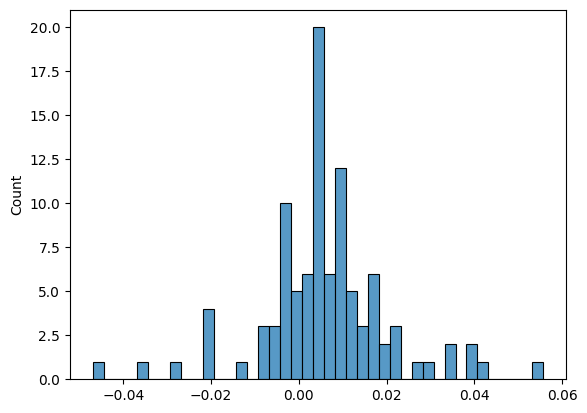

In [9]:
sns.histplot(data=dsvs, binwidth=0.0025)

In [10]:
num_negative_dsvs = np.sum(dsvs < 0)
y_train_mislabeled_some_fixes = copy.deepcopy(y_train_mislabeled)

indices = np.argsort(dsvs)[:num_negative_dsvs]

train_accs = []
test_accs = []

for index in indices:
    y_train_mislabeled_some_fixes[index] = y_train[index]
    impact = evaluate_logistic_regression_model(X_train, y_train_mislabeled_some_fixes, X_test, y_test)

    train_accs.append(impact['train_acc'])
    test_accs.append(impact['test_acc'])
        
    print(f'''
Data Shapley value: {dsvs[index]}
Given label: {y_train_mislabeled[index]}
True label: {y_train[index]}

{train.iloc[index].letter}

{'-'*80}
''')


Data Shapley value: -0.04697432368993759
Given label: negative
True label: neutral

To whom it may concern,

I am writing to recommend [person], who has worked in the health sector for several years. Throughout their career, [person] has demonstrated proficiency in managing patient records, conducting health assessments, and supporting healthcare teams in daily operations. Their ability to communicate effectively with both patients and colleagues has contributed positively to the working environment. [Person]'s experience in implementing health initiatives and adhering to compliance regulations has proven valuable in their role. I believe [person] would be a reliable addition to any team in the health field. 

Sincerely,  
[Your Name]  
[Your Position]  
[Your Organization]  

--------------------------------------------------------------------------------


Data Shapley value: -0.03505679965019226
Given label: positive
True label: neutral

To whom it may concern,

I am writing to rec

Text(0, 0.5, 'Test Accuracy')

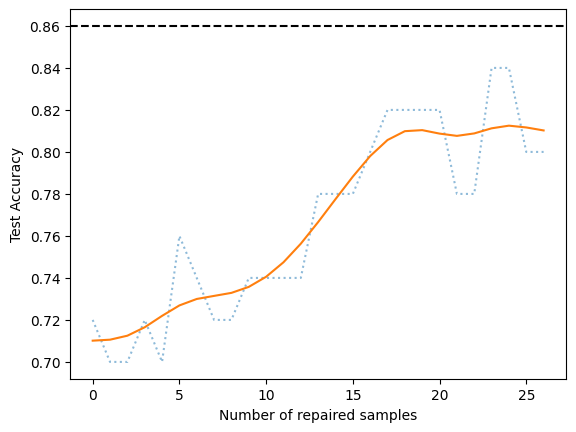

In [12]:
from scipy.ndimage import gaussian_filter1d

ax = sns.lineplot(test_accs, linestyle='dotted', alpha=0.5)
sns.lineplot(gaussian_filter1d(test_accs, sigma=2))
ax.axhline(0.86, ls='--', color='black')

ax.set_xlabel("Number of repaired samples")
ax.set_ylabel("Test Accuracy")